In [229]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import color, segmentation
from tensorflow.examples.tutorials.mnist import input_data

%matplotlib inline

# MNIST
Load a single image from the MNIST test dataset.

Extracting /tmp/mnist/train-images-idx3-ubyte.gz
Extracting /tmp/mnist/train-labels-idx1-ubyte.gz
Extracting /tmp/mnist/t10k-images-idx3-ubyte.gz
Extracting /tmp/mnist/t10k-labels-idx1-ubyte.gz


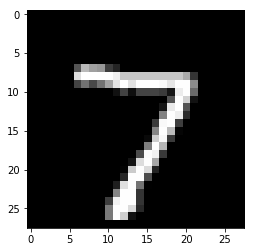

In [230]:
mnist = input_data.read_data_sets('/tmp/mnist')
image = mnist.test.images[0]
image = np.reshape(image, (28, 28))
image = color.gray2rgb(image)
plt.imshow(image)

## SLIC
Segments image using k-means clustering in Color-(x,y,z) space.

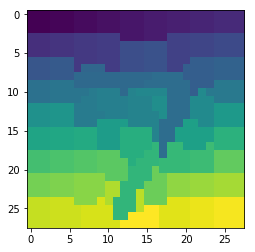

In [231]:
# The (approximate) number of labels in the segmented output image.
N_SEGMENTS = 100
# Balances color proximity and space proximity. Higher values give more weight to space proximity,
# making superpixel shapes more square/cubic. In SLICO mode, this is the initial compactness.
# This parameter depends strongly on image contrast and on the shapes of objects in the image.
COMPACTNESS = 10.0
# Maximum number of iterations of k-means.
MAX_ITER = 10
# Width of Gaussian smoothing kernel for pre-processing for each dimension of the image. The same
# sigma is applied to each dimension in case of a scalar value. Zero means no smoothing.
SIGMA = 0.0
# Whether the generated segments are connected or not.
ENFORCE_CONNECTIVITY = True
# Proportion of the minimum segment size to be removed with respect to the supposed segment size
# `depth*width*height/n_segments`.
MIN_SIZE_FACTOR = 0.5
# Proportion of the maximum connected segment size. A value of 3 works in most of the cases.
MAX_SIZE_FACTOR = 10.0

slic = segmentation.slic(image, N_SEGMENTS, COMPACTNESS, MAX_ITER, SIGMA,
                         enforce_connectivity=ENFORCE_CONNECTIVITY,
                         min_size_factor=MIN_SIZE_FACTOR, max_size_factor=MAX_SIZE_FACTOR)
plt.imshow(slic)

## Quickshift
Segments image using quickshift clustering in Color-(x,y) space.

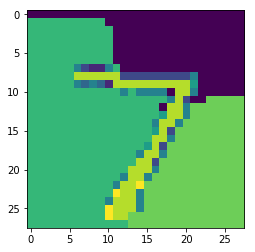

In [232]:
# Balances color-space proximity and image-space proximity. Higher values give more weight to color-space.
RATIO = 1.0
# Width of Gaussian kernel used in smoothing the sample density. Higher means fewer clusters.
KERNEL_SIZE = 3
# Cut-off point for data distances. Higher means fewer clusters.
MAX_DIST = 10
# Width for Gaussian smoothing as preprocessing. Zero means no smoothing.
SIGMA = 0

quickshift = segmentation.quickshift(image, RATIO, KERNEL_SIZE, MAX_DIST, sigma=SIGMA)
plt.imshow(quickshift)

## Felzenszwalb
Computes Felsenszwalb’s efficient graph based image segmentation.

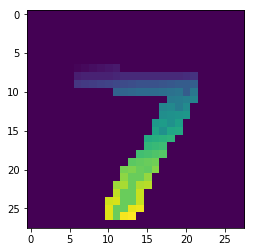

In [233]:
# Higher means larger clusters.
SCALE = 2
# Width of Gaussian kernel used in preprocessing.
SIGMA = 0
# Minimum component size. Enforced using postprocessing.
MIN_SIZE = 1

felzenszwalb = segmentation.felzenszwalb(image, SCALE, SIGMA, MIN_SIZE)
plt.imshow(felzenszwalb)